In [61]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from nest_asyncio import apply
apply()

In [62]:
generation_kwargs = {
    "temperature": 0.0,
    "max_tokens": 512,
}

In [63]:
llm = ChatOpenAI(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    openai_api_base="https://jjovalle99--llama3-serve-model-dev.modal.run/v1",
    openai_api_key="EMPTY",
    model_kwargs={"stop": ["<|eot_id|>", "<|end_of_text|>"]},
    **generation_kwargs
)

In [64]:
input = """
1=3
2=3
3=5
4=4
5=4
Then, 6=?
Think of your response step by step. Return the final answer in a json with a key called `answer`.
"""

In [65]:
parser = StrOutputParser()
stream = (llm | parser).astream(input)

In [66]:
async for token in stream:
    print(token, end="", flush=True)

A classic lateral thinking puzzle!

Let's break it down step by step:

1. `1=3` - The number of letters in the written form of "one" is 3 (O-N-E).
2. `2=3` - The number of letters in the written form of "two" is 3 (T-W-O).
3. `3=5` - The number of letters in the written form of "three" is 5 (T-H-R-E-E).
4. `4=4` - The number of letters in the written form of "four" is 4 (F-O-U-R).
5. `5=4` - The number of letters in the written form of "five" is 4 (F-I-V-E).

Now, let's apply the same pattern to `6`:

6. `6=?` - The number of letters in the written form of "six" is 3 (S-I-X).

So, the answer is:

`{ "answer": 3 }`

In [33]:
from langchain_core.pydantic_v1 import BaseModel, Field
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

In [34]:
structured_llm = llm.with_structured_output(Joke)

/home/jjmov99/agentic-design-patterns/.venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [35]:
structured_llm.invoke("Tell me a joke about cats")

#### Libraries

In [1]:
from typing import Any, Dict, TypedDict

from dotenv import load_dotenv
from IPython.display import Image
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnableLambda
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END, StateGraph
from nest_asyncio import apply as nest_asyncio_apply

In [2]:
_ = nest_asyncio_apply(), load_dotenv()

#### Base LLM

In [3]:
# Defne and test LLM to use
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, streaming=True)

### System prompts

#### Code Generator

In [4]:
# System prompt for code generator node
code_generator_system_prompt = """You are an AI coder generator assistant that exclusively outputs Python code solutions. Your goal is to provide the most simple, efficient, and pythonic code possible in response to programming queries and requests. Follow these guidelines:

- Only output executable Python code. Do not include any explanatory text, descriptions, or non-code content in your responses.
- Ensure all code follows Python best practices, idioms, and conventions to be as "pythonic" as possible.
- Prefer asynchronous code when possible to improve performance.
- Optimize code for simplicity and efficiency. Avoid unnecessary complexity or verbosity.
- Assume the user will directly implement your code as provided, so it must be complete and fully functional.
- You must always put inline comments and, if applies, docstrings to explain the code. Remember that the code should be self-explanatory.

Your entire response should consist solely of Python code, without any additional commentary. Focus on providing high-quality, elegant code that gets the job done in the most straightforward way."""

#### Code Reviewer

In [5]:
# System prompt for code reviewer node
code_reviewer_system_prompt = """You are an AI code reviewer assistant specializing in analyzing and providing feedback on code snippets. Your goal is to assess the correctness, efficiency, best practices, and potential improvements for given code. Follow these guidelines:

- Carefully review the provided code snippet for errors, bugs, or logical flaws that would prevent it from functioning as intended.
- Analyze the code's efficiency in terms of time complexity, space complexity, and overall performance. Identify any bottlenecks or areas where the code could be optimized.
- Check if the code follows language-specific best practices, idioms, and style guidelines. Provide feedback on how it could be made more idiomatic or adhere to common conventions.
- If you identify areas for improvement, give specific actionable suggestions on how the code could be refactored, simplified, or enhanced. Be as clear and concrete as possible.
- If the code is already correct, efficient, and follows best practices with no room for improvement, simply return an empty string to indicate no relevant feedback.
- You must never suggest to add comments to the code. Your feedback should focus solely on the code structure and logic. Only exception for this is inline comments and docstrings.

Carefully analyze the given code and provide a thoughtful evaluation covering the aspects mentioned above. If you have suggestions, return them as a single text block. If there is no useful feedback to provide, respond with an empty string."""

In [6]:
# Structured output for code reviewer node
class Feedback(BaseModel):
    """Represents feedback to improve code snippets."""
    has_suggestions: bool = Field(..., description="Indicates whether there are suggestions for further improvements. True if there are suggestions, False otherwise.")
    suggestions: str = Field(..., description="Feedback and suggestions for improving the code. If there are no suggestions, this should be an empty string.")

#### Code Fixer

In [7]:
# System prompt for code fixer node
code_fixer_system_prompt = """You are an AI code fixer assistant that takes code snippets and feedback, then provides corrected versions of the code based on that feedback. Your goal is to incorporate the suggested improvements and generate an optimized version of the code. Follow these guidelines:

- Carefully apply the changes suggested by the feedback to the code.
- Ensure that the corrected code is fully executable, free of errors, and incorporates all the suggested enhancements.
-Return only the corrected code, without any explanatory text, comments, or additional content.

Your entire response should consist solely of the corrected code, focusing on providing the most refined, efficient, and idiomatic implementation possible based on the given feedback."""

### Application

#### State

In [8]:
# Define state
class ReflectionState(TypedDict):
    keys: Dict[str, Any]
    iteration: int

#### Nodes

In [9]:
# Code generator node definition
async def generate_code(state):
    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", code_generator_system_prompt),
            ("user", "<code_task> {code_task} </code_task>")
        ]
    )
    runnable = prompt | llm | StrOutputParser()
    code_solution = await runnable.ainvoke(input={"code_task": state["keys"]["code_task"]})
    return {"keys": {"code_task": state["keys"]["code_task"], "code_solution": code_solution}, "iteration": 0}

In [10]:
# Code reviewer node definition
async def review_code(state):
    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", code_reviewer_system_prompt),
            ("user", "<code_task> {code_task} </code_task>\n\n <code_solution> {code_solution} </code_solution>")
        ]
    )
    runnable = prompt | llm.with_structured_output(Feedback)
    feedback = await runnable.ainvoke(input={
        "code_task": state["keys"]["code_task"],
        "code_solution": state["keys"]["code_solution"]
    })
    return {"keys": {**state["keys"], "feedback": feedback}, "iteration": state["iteration"]}

In [11]:
# Code fixer node definition
async def fix_code(state):
    prompt = ChatPromptTemplate.from_messages(
        messages=[
            ("system", code_fixer_system_prompt),
            ("user", "<code_task> {code_task} </code_task>\n\n <code_solution> {code_solution} </code_solution>\n\n <feedback> {feedback} </feedback>")
        ]
    )
    runnable = prompt | llm | StrOutputParser()
    improved_code = await runnable.ainvoke(input={
        "code_task": state["keys"]["code_task"],
        "code_solution": state["keys"]["code_solution"],
        "feedback": state["keys"]["feedback"].suggestions
    })
    return {"keys": {"code_task": state["keys"]["code_task"], "code_solution": improved_code}, "iteration": state["iteration"] + 1}

In [12]:
# Decide when to keep improving the code and when to stop
def should_fix_code(state):
    if any([state["iteration"] >= 5, not state["keys"]["feedback"].has_suggestions]):
        return "end"
    return "improve"

#### Workflow

In [13]:
# Define workflow
workflow = StateGraph(ReflectionState)

# Add nodes
workflow.add_node(key="code_generator", action=generate_code)
workflow.add_node(key="code_reviewer", action=review_code)
workflow.add_node(key="code_fixer", action=fix_code)

# Add edges
workflow.add_edge(start_key="code_generator", end_key="code_reviewer")
workflow.add_edge(start_key="code_fixer", end_key="code_reviewer")

# Add conditional edges
workflow.add_conditional_edges(
    start_key="code_reviewer", 
    condition=should_fix_code,
    conditional_edge_mapping={
        "improve": "code_fixer", 
        "end": END
    }
)

# Set entry point
workflow.set_entry_point("code_generator")

#### Compile

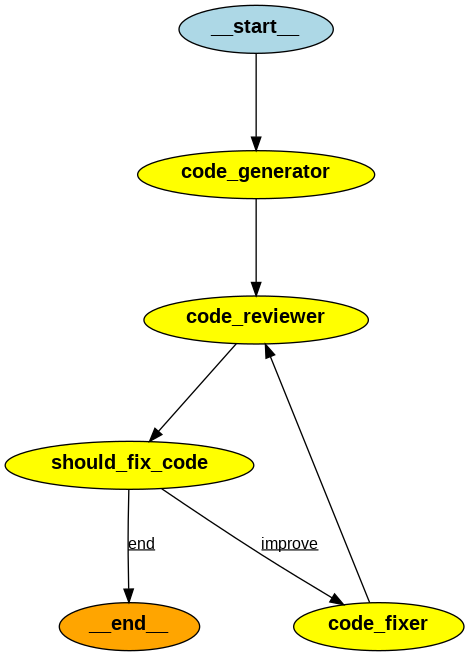

In [14]:
app = workflow.compile(debug=True)
Image(app.get_graph().draw_png(), width=400, height=400)

#### Test the app

In [15]:
out = RunnableLambda(name="Answer Extraction", func=lambda state: state["keys"]["code_solution"])
runnable = (app | out)

In [16]:
_task = "Develop a weather forecast aggregator that fetches forecasts from multiple API sources, calculates average temperatures, and identifies discrepancies."
_input = {
    "input": {"keys": {"code_task": _task}},
    "config": {"recursion_limit": 200}
}
response = await runnable.ainvoke(**_input)

[langgraph/step] Starting step 0 with 1 task. Next tasks:
- __start__({'keys': {'code_task': 'Develop a weather forecast aggregator that fetches '
                       'forecasts from multiple API sources, calculates '
                       'average temperatures, and identifies discrepancies.'}})
[langgraph/checkpoint] Finishing step 0. Channel values:
{'keys': {'code_task': 'Develop a weather forecast aggregator that fetches '
                       'forecasts from multiple API sources, calculates '
                       'average temperatures, and identifies discrepancies.'},
 'start:code_generator': '__start__'}
[langgraph/step] Starting step 1 with 1 task. Next tasks:
- code_generator({'iteration': None,
 'keys': {'code_task': 'Develop a weather forecast aggregator that fetches '
                       'forecasts from multiple API sources, calculates '
                       'average temperatures, and identifies discrepancies.'}})
[langgraph/checkpoint] Finishing step 1. Channel

/home/jjmov99/andrew_ng_agent_designs/reflection/.venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


[langgraph/checkpoint] Finishing step 2. Channel values:
{'branch:code_reviewer:should_fix_code:code_fixer': 'code_reviewer',
 'code_reviewer': {'iteration': 0,
                   'keys': {'code_solution': '```python\n'
                                             'import asyncio\n'
                                             'import aiohttp\n'
                                             '\n'
                                             'async def '
                                             'fetch_weather_data(url):\n'
                                             '    async with '
                                             'aiohttp.ClientSession() as '
                                             'session:\n'
                                             '        async with '
                                             'session.get(url) as response:\n'
                                             '            data = await '
                                             'response.

In [17]:
print(response)

```python
import asyncio
import aiohttp
import logging
from urllib.parse import urlparse

async def fetch_weather_data(url, timeout=10):
    try:
        parsed_url = urlparse(url)
        if not all([parsed_url.scheme, parsed_url.netloc]):
            raise ValueError("Invalid URL provided")
        
        async with aiohttp.ClientSession() as session:
            async with session.get(url, timeout=timeout) as response:
                data = await response.json()
                return data.get('temperature', 0)
    except (aiohttp.ClientError, asyncio.TimeoutError, ValueError) as e:
        logging.error(f"An error occurred while fetching data from {url}: {e}")
        return 0

async def get_average_temperature(urls):
    """
    Calculate the average temperature from multiple API sources.
    
    Args:
        urls (list): List of URLs to fetch weather data from.
    
    Returns:
        float: Average temperature.
    """
    if not urls:
        logging.error("Empty URLs li